In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import pywt
from scipy.signal import welch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from xgboost import XGBClassifier

In [2]:
import numpy as np
import pywt
from scipy.signal import welch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGUtil:
    @staticmethod
    def load_data(file_path, column_name='BCI'):
        """Load EEG data from a CSV file."""
        data = pd.read_csv(file_path)
        signal = data[column_name].values
        return signal

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=-1):
        """Pad or truncate signal to the target length with various strategies."""
        signal = np.array(signal)
        current_length = len(signal)
        
        if current_length >= target_length:
            return signal[:target_length]

        padding_size = target_length - current_length

        if mode == "constant":
            return np.pad(signal, (0, padding_size), 'constant', constant_values=constant_value)
        elif mode == "reflect":
            return np.pad(signal, (0, padding_size), 'reflect')
        elif mode == "cyclic":
            return np.pad(signal, (0, padding_size), 'wrap')
        elif mode == "edge":
            return np.pad(signal, (0, padding_size), 'edge')
        elif mode == "random":
            random_padding = np.random.uniform(low=np.min(signal), high=np.max(signal), size=padding_size)
            return np.concatenate((signal, random_padding))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

    @staticmethod
    def wavelet_transform(signal):
        """Perform Wavelet Transform and extract features."""
        coeffs = pywt.wavedec(signal, 'db4', level=5)
        features = []
        for i in range(1, len(coeffs)):
            features.extend([np.mean(coeffs[i]), np.std(coeffs[i])])
        return np.array(features)

    @staticmethod
    def psd_transform(signal, fs=0.2, nperseg=128):
        """Perform Power Spectral Density analysis and extract features."""
        _, psd = welch(signal, fs=fs, nperseg=nperseg)
        return psd

In [3]:
class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, target_length=600, strategy='padding', padding_mode="constant", use_labels=False):
        """
        Dataset for EEG signals with various preprocessing strategies.
        
        Parameters:
        - data_folder: str, folder containing EEG data files.
        - outcome_file: str, path to CSV file containing outcomes (optional).
        - target_length: int, length to pad/truncate signals to.
        - strategy: str, preprocessing strategy ('padding', 'wavelet', 'psd').
        - padding_mode: str, padding mode for 'padding' strategy.
        - use_labels: bool, whether to load labels from the outcome file.
        """
        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
        
        # Load outcomes if provided
        self.outcome_dict = {}
        if use_labels and outcome_file is not None:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            # Only retain files with labels
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        patient_id = filename.split('.')[0]
        file_path = os.path.join(self.data_folder, filename)
        signal = EEGUtil.load_data(file_path, column_name='spike hz')

        # Process the signal
        processed_signal = self.process_signal(signal)

        # Get the label if available
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)
            
        return torch.tensor(processed_signal, dtype=torch.float32).unsqueeze(0), label  # Add channel dimension

    def process_signal(self, signal):
        if self.strategy == 'padding':
            return EEGUtil.padding(signal, self.target_length, mode=self.padding_mode)
        elif self.strategy == 'wavelet':
            return EEGUtil.wavelet_transform(signal)
        elif self.strategy == 'psd':
            return EEGUtil.psd_transform(signal)
        else:
            raise ValueError("Invalid processing strategy")

    def get_label(self, patient_id):
        if patient_id in self.outcome_dict:
            outcome = self.outcome_dict[patient_id]
            return 1 if outcome == 'Good Outcome' else 0

In [4]:
initial_channels = 128
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoder, self).__init__()
        self.latent_dim = latent_dim

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for i in range(3):  # 3 more layers to make 4 in total
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.fc_mean = nn.Linear(in_channels * seq_length, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * seq_length, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)  # Match the output channel of the encoder

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for i in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        # Remove the last LeakyReLU and add a final ConvTranspose to match the Encoder's starting channel
        layers.pop()
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)
        return z

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [5]:
def train(model, dataloader, optimizer, criterion, alpha, kl_loss_enabled=True):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for data, label in dataloader:  # We don't use the labels during unsupervised training for VAE
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass through the model
        reconstruction, mean, logvar = model(data)

        # Compute the reconstruction loss (mean squared error)
        recon_loss = criterion(reconstruction, data)

        # Compute the KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

        # Combine the losses
        loss = recon_loss + (alpha * kl_loss if kl_loss_enabled else 0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)  # Accumulate the total loss for this batch

    epoch_loss = running_loss / len(dataloader.dataset)  # Calculate the average loss per sample
    return epoch_loss


def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data, label in dataloader:  # 注意：解包数据，将信号和标签分别取出
            data = data.to(device)
            reconstruction, _, _ = model(data)
            loss = criterion(reconstruction, data)
            running_loss += loss.item() * data.size(0)
    return running_loss / len(dataloader.dataset)

def get_latent_variables(model, dataloader):
    model.eval()
    all_latent_vars = []
    with torch.no_grad():
        for data, label  in dataloader:
            data = data.to(device)
            _, mean, _ = model(data)
            all_latent_vars.append(mean.detach().cpu())
    return torch.cat(all_latent_vars)

In [6]:
def extract_latent_features(vae_model, dataset):
    latent_features = []
    labels = []

    for i in range(len(dataset)):
        signal, label = dataset[i]  # 从数据集中获取信号和标签

        # 将信号放入设备
        signal = signal.unsqueeze(0).to(device)  # 增加 batch 维度

        # 获取潜在表示
        with torch.no_grad():
            latent_vector = vae_model.get_embedding(signal).cpu().numpy()
        latent_features.append(latent_vector.flatten())

        
        
        labels.append(label)

    return np.array(latent_features), np.array(labels)


=== Experiment with Padding Mode: constant ===
Epoch 1/100, Train Loss: 1.1426, Test Loss: 0.9466
Epoch 2/100, Train Loss: 0.9198, Test Loss: 0.7692
Epoch 3/100, Train Loss: 0.5170, Test Loss: 0.4085
Epoch 4/100, Train Loss: 0.3940, Test Loss: 0.3714
Epoch 5/100, Train Loss: 0.3895, Test Loss: 0.3670
Epoch 6/100, Train Loss: 0.3622, Test Loss: 0.3556
Epoch 7/100, Train Loss: 0.3471, Test Loss: 0.3465
Epoch 8/100, Train Loss: 0.3421, Test Loss: 0.3412
Epoch 9/100, Train Loss: 0.3399, Test Loss: 0.3402
Epoch 10/100, Train Loss: 0.3381, Test Loss: 0.3385
Epoch 11/100, Train Loss: 0.3365, Test Loss: 0.3369
Epoch 12/100, Train Loss: 0.3344, Test Loss: 0.3349
Epoch 13/100, Train Loss: 0.3314, Test Loss: 0.3308
Epoch 14/100, Train Loss: 0.3256, Test Loss: 0.3222
Epoch 15/100, Train Loss: 0.3131, Test Loss: 0.3053
Epoch 16/100, Train Loss: 0.2989, Test Loss: 0.2881
Epoch 17/100, Train Loss: 0.2816, Test Loss: 0.2619
Epoch 18/100, Train Loss: 0.2543, Test Loss: 0.2579
Epoch 19/100, Train Loss:

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.



=== Results for Padding Mode: constant ===
Accuracy: 0.7833

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.20      0.10      0.13        10

    accuracy                           0.78        60
   macro avg       0.52      0.51      0.50        60
weighted avg       0.73      0.78      0.75        60


Confusion Matrix:
[[46  4]
 [ 9  1]]

=== Experiment with Padding Mode: reflect ===
Epoch 1/100, Train Loss: 0.2760, Test Loss: 0.0898
Epoch 2/100, Train Loss: 0.1316, Test Loss: 0.0777
Epoch 3/100, Train Loss: 0.1222, Test Loss: 0.0758
Epoch 4/100, Train Loss: 0.1193, Test Loss: 0.0748
Epoch 5/100, Train Loss: 0.1178, Test Loss: 0.0741
Epoch 6/100, Train Loss: 0.1168, Test Loss: 0.0733
Epoch 7/100, Train Loss: 0.1147, Test Loss: 0.0745
Epoch 8/100, Train Loss: 0.1128, Test Loss: 0.0715
Epoch 9/100, Train Loss: 0.1091, Test Loss: 0.0804
Epoch 10/100, Train Loss: 0.1121, Test Loss:

Epoch 10/100, Train Loss: 0.1419, Test Loss: 0.1672
Epoch 11/100, Train Loss: 0.1398, Test Loss: 0.1654
Epoch 12/100, Train Loss: 0.1387, Test Loss: 0.1663
Epoch 13/100, Train Loss: 0.1374, Test Loss: 0.1616
Epoch 14/100, Train Loss: 0.1346, Test Loss: 0.1657
Epoch 15/100, Train Loss: 0.1364, Test Loss: 0.1768
Epoch 16/100, Train Loss: 0.1408, Test Loss: 0.1733
Epoch 17/100, Train Loss: 0.1361, Test Loss: 0.1567
Epoch 18/100, Train Loss: 0.1301, Test Loss: 0.1548
Epoch 19/100, Train Loss: 0.1280, Test Loss: 0.1545
Epoch 20/100, Train Loss: 0.1276, Test Loss: 0.1523
Epoch 21/100, Train Loss: 0.1264, Test Loss: 0.1513
Epoch 22/100, Train Loss: 0.1261, Test Loss: 0.1533
Epoch 23/100, Train Loss: 0.1266, Test Loss: 0.1537
Epoch 24/100, Train Loss: 0.1252, Test Loss: 0.1514
Epoch 25/100, Train Loss: 0.1241, Test Loss: 0.1502
Epoch 26/100, Train Loss: 0.1249, Test Loss: 0.1486
Epoch 27/100, Train Loss: 0.1227, Test Loss: 0.1488
Epoch 28/100, Train Loss: 0.1226, Test Loss: 0.1504
Epoch 29/100

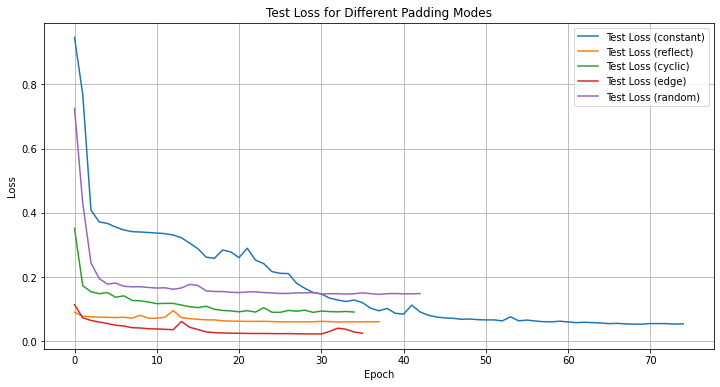


Final Classification Accuracy for Each Padding Mode:
Constant Padding: Accuracy = 0.7833
Reflect Padding: Accuracy = 0.8000
Cyclic Padding: Accuracy = 0.7833
Edge Padding: Accuracy = 0.8333
Random Padding: Accuracy = 0.7833


In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 定义不同的填充策略
padding_modes = ["constant", "reflect", "cyclic", "edge", "random"]

# 存储每种策略的实验结果
results = {mode: {"train_losses": [], "test_losses": [], "accuracy": None, "classification_report": None, "confusion_matrix": None} for mode in padding_modes}

# 超参数设置
latent_dim = 7
seq_length = 1139
batch_size = 32
epochs = 100
alpha = 1e-6
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据文件路径
data_folder = '5min_smoothed_data/'
outcome_file = 'valid_patients_outcome.csv'

for mode in padding_modes:
    print(f"\n=== Experiment with Padding Mode: {mode} ===")
    
    # Step 1: 数据加载与处理
    eeg_dataset = EEGDataset(data_folder, outcome_file, target_length=seq_length, strategy='padding', padding_mode=mode, use_labels=False)
    train_size = int(0.8 * len(eeg_dataset))
    test_size = len(eeg_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Step 2: 定义模型并训练
    vae_model = VAE(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, weight_decay=1e-4)

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        train_loss = train(vae_model, train_loader, optimizer, criterion, alpha)
        test_loss = test(vae_model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # 早停机制
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping after {patience} epochs without improvement.")
            break
    
    results[mode]["train_losses"] = train_losses
    results[mode]["test_losses"] = test_losses

    # Step 3: 提取潜在特征和标签
    eeg_dataset = EEGDataset(data_folder, outcome_file, target_length=seq_length, strategy='padding', padding_mode=mode, use_labels=True)
    latent_features, labels = extract_latent_features(vae_model, eeg_dataset)

    # Step 4: 划分训练集和测试集（分类任务）
    X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.2, random_state=42, stratify=labels)

    # Step 5: 训练 XGBoost 分类器
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(X_train, y_train)

    # Step 6: 测试并评估分类器
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[mode]["accuracy"] = accuracy
    results[mode]["classification_report"] = class_report
    results[mode]["confusion_matrix"] = conf_matrix

    print(f"\n=== Results for Padding Mode: {mode} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

# 绘制各填充模式的测试损失曲线
plt.figure(figsize=(12, 6))
for mode in padding_modes:
    plt.plot(results[mode]["test_losses"], label=f'Test Loss ({mode})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss for Different Padding Modes')
plt.legend()
plt.grid(True)
plt.show()

# 打印所有填充模式的最终分类精度
print("\nFinal Classification Accuracy for Each Padding Mode:")
for mode in padding_modes:
    print(f"{mode.capitalize()} Padding: Accuracy = {results[mode]['accuracy']:.4f}")

Epoch 1/100, Train Loss: 0.8694, Test Loss: 0.5192
Epoch 2/100, Train Loss: 0.5568, Test Loss: 0.3598
Epoch 3/100, Train Loss: 0.4753, Test Loss: 0.3346
Epoch 4/100, Train Loss: 0.4550, Test Loss: 0.3258
Epoch 5/100, Train Loss: 0.4461, Test Loss: 0.3195
Epoch 6/100, Train Loss: 0.3612, Test Loss: 0.2676
Epoch 7/100, Train Loss: 0.2417, Test Loss: 0.2408
Epoch 8/100, Train Loss: 0.2289, Test Loss: 0.2113
Epoch 9/100, Train Loss: 0.2079, Test Loss: 0.2075
Epoch 10/100, Train Loss: 0.1934, Test Loss: 0.1922
Epoch 11/100, Train Loss: 0.1726, Test Loss: 0.1726
Epoch 12/100, Train Loss: 0.1514, Test Loss: 0.1500
Epoch 13/100, Train Loss: 0.1243, Test Loss: 0.1274
Epoch 14/100, Train Loss: 0.1217, Test Loss: 0.1248
Epoch 15/100, Train Loss: 0.1086, Test Loss: 0.1213
Epoch 16/100, Train Loss: 0.1018, Test Loss: 0.1045
Epoch 17/100, Train Loss: 0.0894, Test Loss: 0.0964
Epoch 18/100, Train Loss: 0.0856, Test Loss: 0.0906
Epoch 19/100, Train Loss: 0.0796, Test Loss: 0.0967
Epoch 20/100, Train L

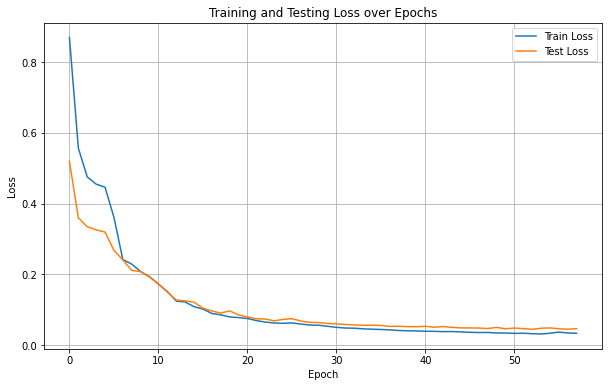

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

# 設置設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超參數設置
latent_dim = 7  # 潛在空間的維度
initial_channels = 128  # CNN 的初始通道數
seq_length = 175  # 填充或截斷的序列長度 此處設為最長
batch_size = 32
epochs = 100
alpha = 1e-6  # KL 損失的權重
patience = 5  # 定义在多少个 epoch 不改善后停止训练
padding_method='constant'# 使用反射填充

# 定義數據文件夾路徑
data_folder = '5min_smoothed_data/'  # 替換為你實際的數據文件夾路徑
valid_outcome_data = 'valid_patients_outcome.csv'

# 创建 EEG 数据集并使用不同的填充模式
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    target_length=seq_length ,
    strategy='padding',
    padding_mode= padding_method, 
    use_labels=False
)
train_size = int(0.8 * len(eeg_dataset))
test_size = len(eeg_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 定义模型、损失函数和优化器
vae_model = VAE(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, weight_decay=1e-4)

# 训练和测试损失列表，用于绘制曲线
train_losses = []
test_losses = []

# 早停相关变量
best_test_loss = float('inf')
epochs_no_improve = 0

# 训练循环
for epoch in range(epochs):
    train_loss = train(vae_model, train_loader, optimizer, criterion, alpha)
    test_loss = test(vae_model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # 检查早停条件
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print("Validation loss has not improved for {} epochs. Early stopping...".format(patience))
        break
        
        
# 绘制训练和测试损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# 创建 EEG 数据集和数据加载器
# 创建 EEG 数据集并使用不同的填充模式
# 如果只想读取有标签的数据
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,  # 使用反射填充
    use_labels=True
)

# 提取潜在特征和标签
latent_features, labels = extract_latent_features(vae_model, eeg_dataset)

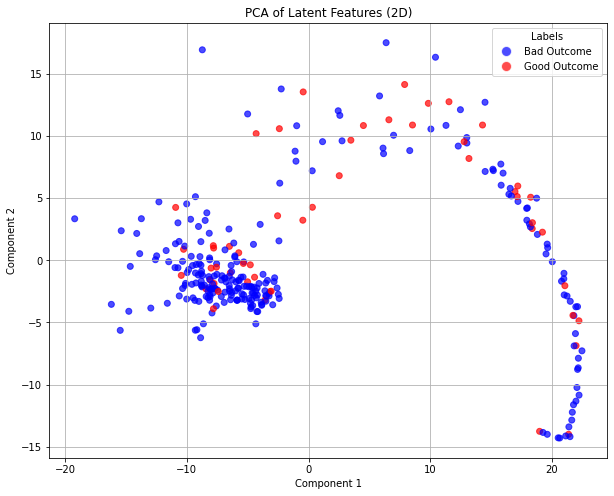

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


def visualize_latent_space(latent_features, labels, method='pca', dimensions=2):
    """
    将潜在特征降维并可视化，支持二维或三维图形。
    
    参数：
    - latent_features: 2D numpy array，形状为 (样本数, 特征维度)
    - labels: 1D numpy array，样本标签
    - method: str, 降维方法 ('pca' 或 'tsne')
    - dimensions: int, 降维到2维或3维 (2或3)
    """
    if dimensions not in [2, 3]:
        raise ValueError("Dimensions must be 2 or 3.")

    # 降维
    if method == 'pca':
        reducer = PCA(n_components=dimensions)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"PCA of Latent Features ({dimensions}D)"
    elif method == 'tsne':
        reducer = TSNE(n_components=dimensions, random_state=42)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"t-SNE of Latent Features ({dimensions}D)"
    else:
        raise ValueError("Method should be 'pca' or 'tsne'.")

    # 可视化
    if dimensions == 2:
        %matplotlib inline
        # 二维散点图
        plt.figure(figsize=(10, 8))
        color_map = {0: 'blue', 1: 'red'}
        label_map = {0: 'Bad Outcome', 1: 'Good Outcome'}
        colors = [color_map[label] for label in labels]
        scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)
        
        # 创建自定义图例
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        plt.legend(handles=handles, title="Labels")
        plt.title(title)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.grid(True)
        plt.show()

        
    elif dimensions == 3:
        %matplotlib notebook
        # 三维散点图
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        color_map = {0: 'blue', 1: 'red'}
        label_map = {0: 'Bad Outcome', 1: 'Good Outcome'}
        colors = [color_map[label] for label in labels]

        scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=colors, alpha=0.7)

        # 创建自定义图例
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        ax.legend(handles=handles, title="Labels")
        ax.set_title(title)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")

        # 显示交互式图形
        plt.show()

        
        
# 调用可视化函数

visualize_latent_space(latent_features, labels, method='pca', dimensions=2) 
# 可设置'dimensions=2'或'dimensions=3'





In [26]:
from sklearn.model_selection import train_test_split

# 确保 labels 是 numpy 数组
labels = np.array(labels)

# 使用分层划分进行训练和测试集划分
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.3, stratify=labels, random_state=42)

print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

Training set class distribution: [172  36]
Testing set class distribution: [74 16]


In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 创建并训练 SVM 模型
svm_model = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

# 预测并评估模型
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of SVM on latent features: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy of SVM on latent features: 0.5556

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.59      0.69        74
           1       0.17      0.38      0.23        16

    accuracy                           0.56        90
   macro avg       0.49      0.48      0.46        90
weighted avg       0.70      0.56      0.61        90


Confusion Matrix:
[[44 30]
 [10  6]]


In [28]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # 设定不使用标签编码
xgb_model.fit(X_train, y_train)

# 9. 预测并评估模型
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


print(f"Accuracy of XGB on latent features: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy of XGB on latent features: 0.7111

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        74
           1       0.08      0.06      0.07        16

    accuracy                           0.71        90
   macro avg       0.45      0.46      0.45        90
weighted avg       0.68      0.71      0.69        90


Confusion Matrix:
[[63 11]
 [15  1]]


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# 列出所有分类器
classifiers = {
    'SVM': SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# 使用分层划分进行训练和测试集划分
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.3, stratify=labels, random_state=42)

# 循环遍历每个分类器进行训练和评估
for name, classifier in classifiers.items():
    # 创建并训练分类器
    classifier.fit(X_train, y_train)

    # 预测并评估模型
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 打印分类结果
    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("=" * 50)  # 分隔线

Classifier: SVM
Accuracy: 0.5556

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.59      0.69        74
           1       0.17      0.38      0.23        16

    accuracy                           0.56        90
   macro avg       0.49      0.48      0.46        90
weighted avg       0.70      0.56      0.61        90


Confusion Matrix:
[[44 30]
 [10  6]]
Classifier: Random Forest
Accuracy: 0.7444

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        74
           1       0.18      0.12      0.15        16

    accuracy                           0.74        90
   macro avg       0.50      0.50      0.50        90
weighted avg       0.71      0.74      0.72        90


Confusion Matrix:
[[65  9]
 [14  2]]
Classifier: Logistic Regression
Accuracy: 0.7889

Classification Report:
              precision    recall  f1-score   support

           0      